In [13]:
# 명령 결과 모두 보기
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 버전 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 판다스와 넘피
import pandas as pd
import numpy as np

# 그림 그리기
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트

# 자료 스케일링
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 모델 선택
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# 성능지표
from sklearn.metrics import accuracy_score, plot_roc_curve 
from sklearn.metrics import plot_confusion_matrix, classification_report

# 파이프라인
from sklearn.pipeline import Pipeline, make_pipeline

# 시각화 툴
import scikitplot as skplt

# 모델저장
from joblib import dump, load

# In Depth: Linear Regression

Linear regression models are a good starting point for regression tasks.
Such models are popular because they can be fit very quickly, and are very interpretable.
You are probably familiar with the simplest form of a linear regression model (i.e., fitting a straight line to data) but such models can be extended to model more complicated data behavior.

In this section we will start with a quick intuitive walk-through of the mathematics behind this well-known problem, before seeing how before moving on to see how linear models can be generalized to account for more complicated patterns in data.

We begin with the standard imports:

## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form
$$
y = ax + b
$$
where $a$ is commonly known as the *slope*, and $b$ is commonly known as the *intercept*.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

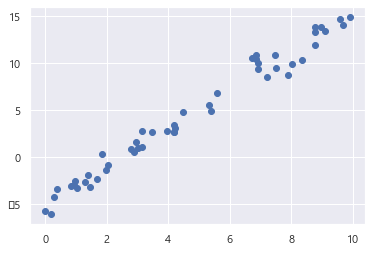

In [14]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

We can use Scikit-Learn's ``LinearRegression`` estimator to fit this data and construct the best-fit line:

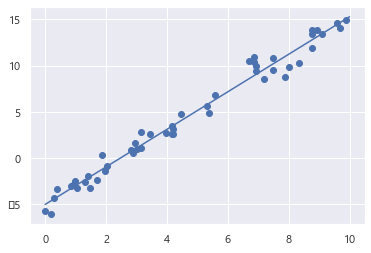

In [18]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore.
Here the relevant parameters are ``coef_`` and ``intercept_``:

In [19]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.0272088103606944
Model intercept: -4.9985770855532


We see that the results are very close to the inputs, as we might hope.

The ``LinearRegression`` estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$
where there are multiple $x$ values.
Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [20]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

LinearRegression()

0.50000000000001
[ 1.5 -2.   1. ]


Here the $y$ data is constructed from three random $x$ values, and the linear regression recovers the coefficients used to construct the data.

In this way, we can use the single ``LinearRegression`` estimator to fit lines, planes, or hyperplanes to our data.
It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

## Basis Function Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*.
We have seen one version of this before, in the ``PolynomialRegression`` pipeline used in [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) and [Feature Engineering](05.04-Feature-Engineering.ipynb).
The idea is to take our multidimensional linear model:
$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$
and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$.
That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:
$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$
Notice that this is *still a linear model*—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other.
What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

### Polynomial basis functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the ``PolynomialFeatures`` transformer:

In [21]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(5, include_bias=False)
poly.fit_transform(x[:, None])

array([[   2.,    4.,    8.,   16.,   32.],
       [   3.,    9.,   27.,   81.,  243.],
       [   4.,   16.,   64.,  256., 1024.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value.
This new, higher-dimensional data representation can then be plugged into a linear regression.

As we saw in [Feature Engineering](05.04-Feature-Engineering.ipynb), the cleanest way to accomplish this is to use a pipeline.
Let's make a 7th-degree polynomial model in this way:

In [22]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

With this transform in place, we can use the linear model to fit much more complicated relationships between $x$ and $y$. 
For example, here is a sine wave with noise:

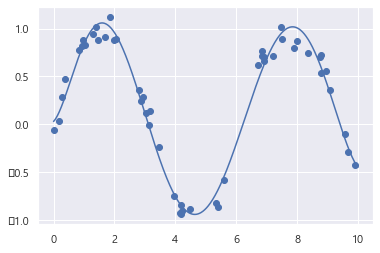

In [23]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

Our linear model, through the use of 7th-order polynomial basis functions, can provide an excellent fit to this non-linear data!

## Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) for a discussion of this).
For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:

계수값 [ 0.00000000e+00  1.01361307e+00  1.16555905e+00 -2.47020285e+00
  1.86385756e+00 -7.94023457e-01  2.02346794e-01 -3.11089225e-02
  2.82217225e-03 -1.39109586e-04  2.87416569e-06]


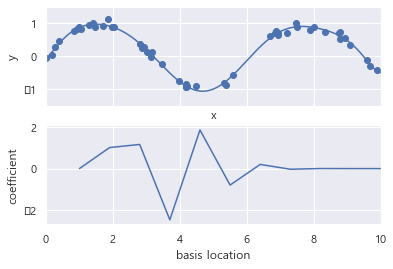

In [24]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y) # model.fit(x.reshape(-1,1), y) X는 항상 행렬이이어함
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(np.linspace(1,N, N+1), 
               model.steps[1][1].coef_)
    print('계수값', model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
N = 10
model = make_pipeline(PolynomialFeatures(N), LinearRegression())
basis_plot(model)

### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as *ridge regression* or $L_2$ *regularization*, sometimes also called *Tikhonov regularization*.
This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be 
$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$
where $\alpha$ is a free parameter that controls the strength of the penalty.
This type of penalized model is built into Scikit-Learn with the ``Ridge`` estimator:

계수값 [ 0.00000000e+00  8.04825789e-01  9.27343118e-02 -1.75261166e-01
  7.11676916e-02 -5.99851840e-02  2.60827067e-02 -5.38619664e-03
  5.76091732e-04 -3.11521912e-05  6.76636154e-07]


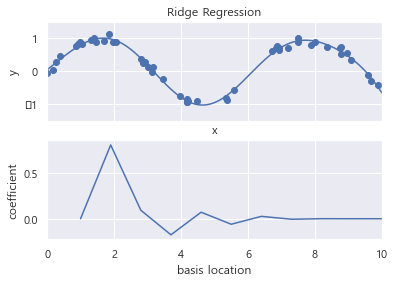

In [25]:
from sklearn.linear_model import Ridge
model = make_pipeline(PolynomialFeatures(N), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model.
In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed.
One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

### Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:
$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$
Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor *sparse models* where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients:

계수값 [ 0.00000000e+00 -1.12235296e-02 -1.59227637e-01  2.00544093e-02
  8.79779049e-04 -1.43686245e-05 -5.60776916e-06 -5.58917716e-07
 -3.49228877e-08 -6.82035976e-10  2.11110357e-10]


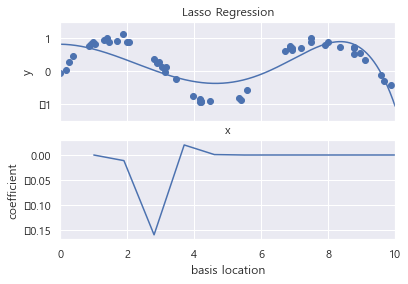

In [26]:
from sklearn.linear_model import Lasso
model = make_pipeline(PolynomialFeatures(N), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

## 로지스틱 회귀(Logistic regression)

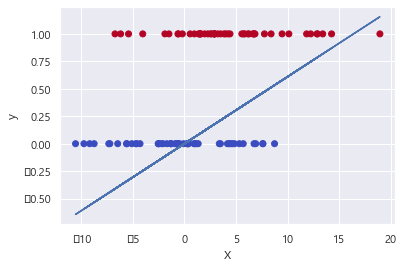

In [32]:
from sklearn.datasets import make_blobs
import statsmodels.api as sm
X, y = make_blobs(100, 1, centers=2, random_state=14, cluster_std=5)
y_predict = sm.OLS(y, X).fit().predict(X)
plt.scatter(X[:, 0], y, c=y, cmap='coolwarm')
plt.plot(X, y_predict); plt.ylabel('y'); plt.xlabel('X'); 

Optimization terminated successfully.
         Current function value: 0.601782
         Iterations 5


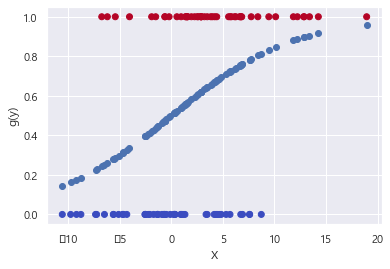

In [33]:
y_predict = sm.Logit(y, X).fit().predict(X) 
plt.scatter(X[:, 0], y, c=y, cmap='coolwarm')
plt.scatter(X, y_predict); plt.ylabel('g(y)'); plt.xlabel('X'); 

In [34]:
rng = np.random.RandomState(1234)
X = 10 * rng.rand(100); X.shape
y = np.cos(X) + 0.25 * rng.randn(100)
X = X.reshape(-1,1); X.shape # X = X[:,np.newaxis] 

(100,)

(100, 1)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=20)),
                ('linearregression', LinearRegression())])

<Figure size 1080x576 with 0 Axes>

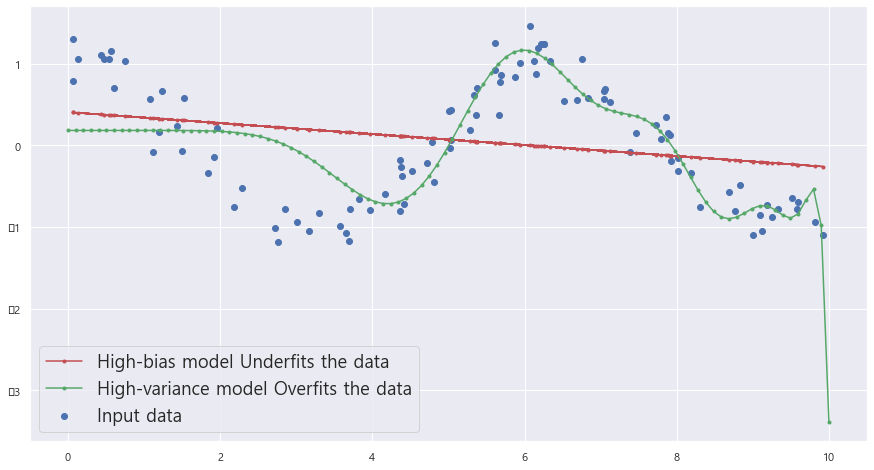

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
y_predict = LinearRegression().fit(X,y).predict(X)
poly_model = make_pipeline(PolynomialFeatures(20), LinearRegression())
poly_model.fit(X, y)
Xfit = np.linspace(0, 10, 100)
yfit = poly_model.predict(Xfit[:,np.newaxis])

plt.figure(figsize=(15, 8));  plt.rc('legend', fontsize=18)
plt.scatter(X, y, label='Input data'); plt.legend()
plt.plot(X, y_predict, 'r.-', label='High-bias model Underfits the data'); plt.legend()
plt.plot(Xfit, yfit, 'g.-', label='High-variance model Overfits the data'); plt.legend()

In [37]:
new_data = np.array([[11.00]])
poly_model.predict(new_data)
LinearRegression().fit(X,y).predict(new_data)

array([-4460.00850736])

array([-0.33203872])

<Figure size 1080x576 with 0 Axes>

(-4.0, 4.0)

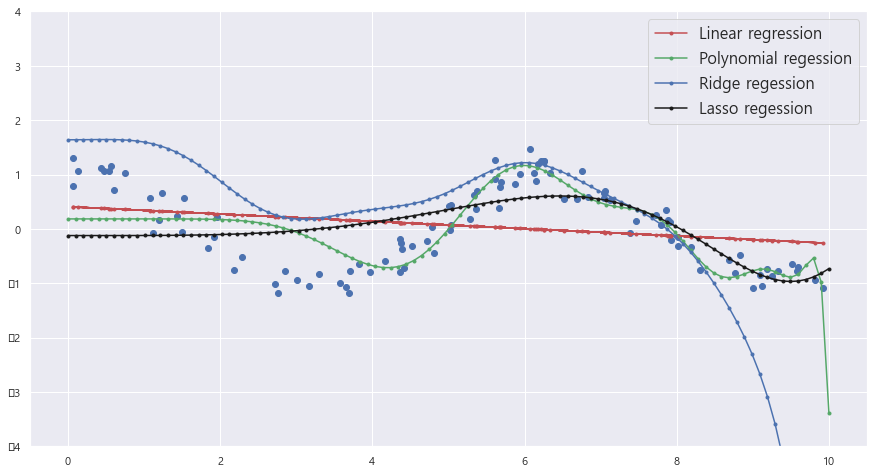

In [38]:
from sklearn.linear_model import Ridge, Lasso
lasso_model = make_pipeline(PolynomialFeatures(20), Lasso(alpha= 1))
predict_lasso = lasso_model.fit(X, y).predict(Xfit[:,np.newaxis])
ridge_model = make_pipeline(PolynomialFeatures(20), Ridge(alpha= 30))
predict_ridge = ridge_model.fit(X, y).predict(Xfit[:,np.newaxis])

plt.figure(figsize=(15, 8)); plt.rc('legend', fontsize=16)
plt.scatter(X, y)
plt.plot(X, y_predict, 'r.-', label='Linear regression'); plt.legend()
plt.plot(Xfit, yfit, 'g.-', label='Polynomial regession'); plt.legend()
plt.plot(Xfit, predict_ridge, 'b.-', label='Ridge regession'); plt.legend()
plt.plot(Xfit, predict_lasso, 'k.-', label='Lasso regession'); plt.legend()
plt.ylim(-4, 4)

## 데이터 읽고 훈련시험 데이터 준비

In [29]:
dir_path = 'd:/한양대학교/data/'

In [30]:
X = pd.read_pickle(dir_path + 'X.pkl') # 특성변수만 반영
y = pd.read_pickle(dir_path + 'y.pkl')
X.shape, y.shape
X.head()

((3997, 19), (3997,))

,drama7,지역_부산울산경남,지역_경기인천,tv9,tv4,drama3,drama4,연령,직업_무직기타,지역_대구경북,인터넷평일,tv6,tv3,tv7,drama9,성별_남자,모바일평일,인터넷주말,모바일주말
0,-1.205273,0,0,2.30963,0.579234,-0.396918,-1.637911,-1.808444,0,0,-1.533759,-0.780005,-0.637110,-0.086913,3.407174,1,1.451424,1.443933,0.900657
1,-1.205273,0,0,-0.43297,0.579234,-0.396918,0.435808,-1.808444,0,0,-0.804841,-0.780005,1.569587,1.308237,-0.293498,1,-0.863126,-0.371716,-0.729510
2,-1.205273,0,0,2.30963,0.579234,-0.396918,0.435808,-1.808444,0,0,0.652994,1.210850,-0.637110,-0.086913,-0.293498,1,0.525604,0.082196,1.222392
3,0.782134,0,0,2.30963,-1.699504,-0.396918,0.435808,-1.808444,0,0,0.139761,1.210850,-0.637110,-0.086913,-0.293498,1,-0.400216,0.379376,-0.338293
4,-1.205273,0,0,2.30963,0.579234,-0.396918,0.435808,-1.808444,0,0,-1.533759,-0.780005,-0.637110,1.308237,-0.293498,1,1.451424,0.082196,1.222392


In [31]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, 
                                                  stratify= y, random_state=11)
X_train.shape, X_test.shape
y_train.shape, y_test.shape

((3197, 19), (800, 19))

((3197,), (800,))

In [39]:
from sklearn.linear_model import LogisticRegression
np.random.seed(1357)

In [40]:
kf = KFold(n_splits=5)
model = LogisticRegression(random_state=11)
model.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [41]:
params = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}
grid = RandomizedSearchCV(model, param_distributions=params, cv=kf,
                          scoring = 'recall_macro')
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LogisticRegression(random_state=11),
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'penalty': ['l1', 'l2']},
                   scoring='recall_macro')

In [42]:
print('optimal train score: {:.3f}'.format(grid.best_score_))
print('test score: {:.3f}'.format(grid.score(X_test, y_test)))
print('optimal parameter: {}'.format(grid.best_params_))

optimal train score: 0.582
test score: 0.571
optimal parameter: {'penalty': 'l2', 'C': 1.623776739188721}


In [43]:
model= LogisticRegression(random_state=11, penalty= 'l2', C=78.47599703514607)
model.fit(X_train, y_train)
model.coef_
model.intercept_

LogisticRegression(C=78.47599703514607, random_state=11)

array([[-0.07619526,  0.94073674, -0.34460647,  0.17936543,  0.19748857,
         0.1510156 , -0.09076182, -0.02118046, -0.12891707, -0.9024209 ,
        -0.13322508, -0.03362007, -0.08065295, -0.0648128 ,  0.06505934,
        -0.30434302, -0.04379854,  0.08836696,  0.1116314 ]])

array([-0.49459641])

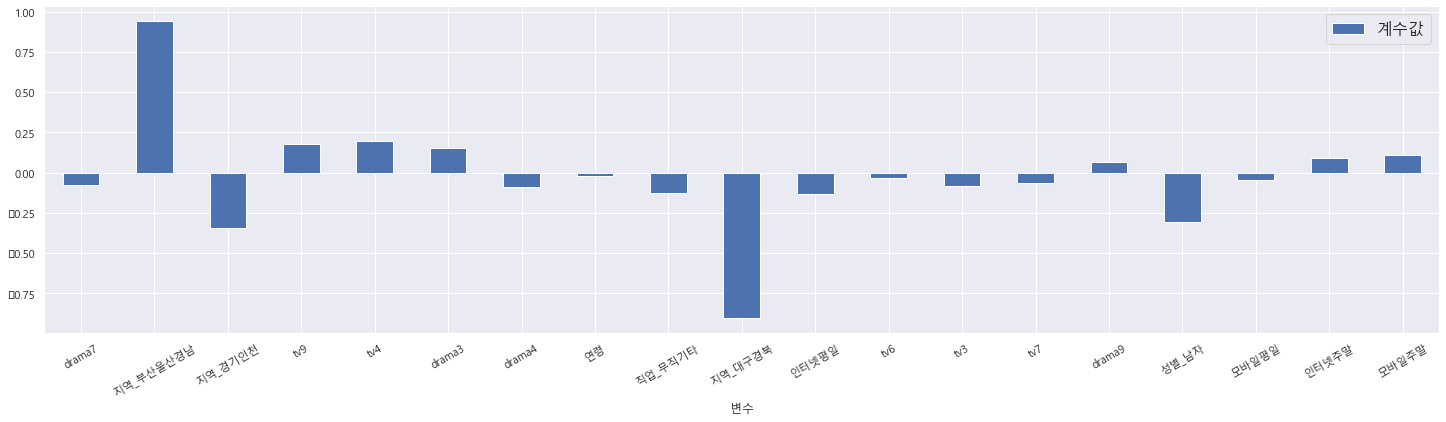

In [44]:
data = zip(X_train.columns, np.squeeze(model.coef_))
(pd.DataFrame(data, columns =['변수', '계수값']).set_index('변수').
plot.bar(rot='30', figsize=(25,6)))

In [45]:
y_predict = model.predict(X_test)
accuracy_score(y_test, y_predict)

0.67

(array([ 47., 133., 129., 186., 132.,  68.,  50.,  27.,  19.,   9.]),
 array([0.06354346, 0.1408437 , 0.21814394, 0.29544418, 0.37274443,
        0.45004467, 0.52734491, 0.60464515, 0.68194539, 0.75924563,
        0.83654587]),
 <a list of 10 Patch objects>)

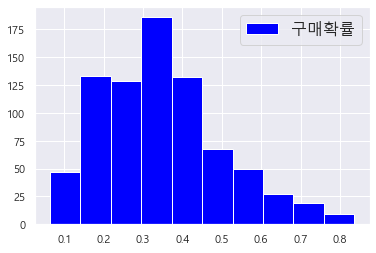

(array([  9.,  19.,  27.,  50.,  68., 132., 186., 129., 133.,  47.]),
 array([0.16345413, 0.24075437, 0.31805461, 0.39535485, 0.47265509,
        0.54995533, 0.62725557, 0.70455582, 0.78185606, 0.8591563 ,
        0.93645654]),
 <a list of 10 Patch objects>)

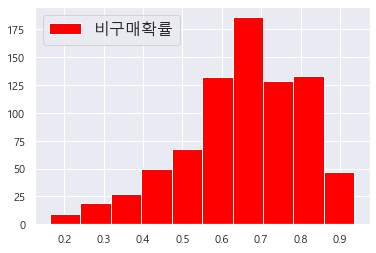

In [46]:
y_proba = model.predict_proba(X_test)
plt.hist(y_proba[:, 1], color ='blue', label='구매확률'); plt.legend(); plt.show()
plt.hist(y_proba[:, 0], color ='red', label='비구매확률'); plt.legend()

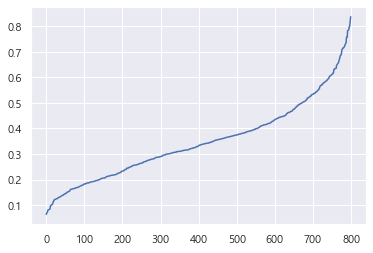

In [47]:
plt.plot(np.arange(len(y_test)), np.sort(y_proba[:,1]))

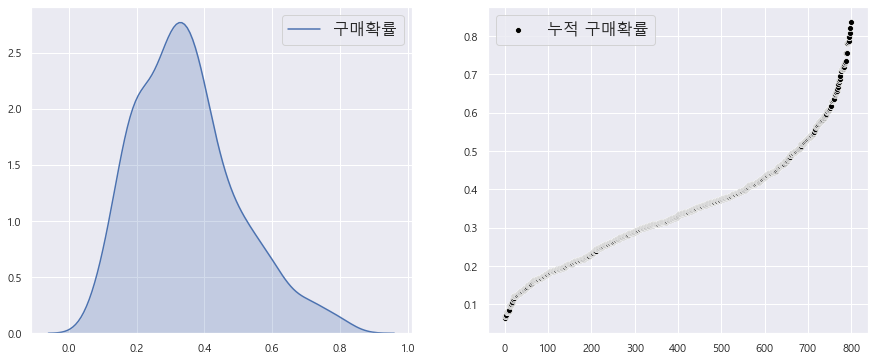

In [48]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6))
sns.kdeplot(np.sort(y_proba[:,1]), shade=True, label='구매확률', ax=ax[0])
x=np.arange(len(y_test)); y=np.sort(y_proba[:,1])
sns.scatterplot(x=x, y=y, color='black', label='누적 구매확률', ax=ax[1])

In [49]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.69      0.89      0.78       522
           1       0.55      0.26      0.35       278

    accuracy                           0.67       800
   macro avg       0.62      0.57      0.56       800
weighted avg       0.64      0.67      0.63       800



In [ ]:
dump(grid.best_estimator_, dir_path + '../output/lgr.joblib')

In [ ]:
model = load('../output/lgr.joblib')
model.get_params()['solver']

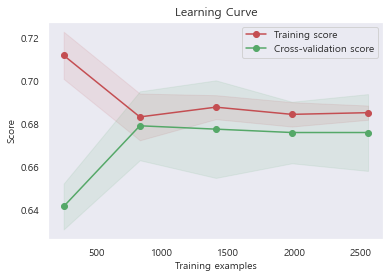

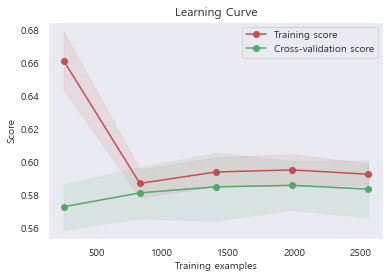

In [50]:
skplt.estimators.plot_learning_curve(model, X_train, y_train, scoring='accuracy')
skplt.estimators.plot_learning_curve(model, X_train, y_train, scoring='recall_macro')